In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


In [55]:
import pandas as pd
import numpy as np

# Addressing the "tweet" column
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier

# Saving the model
import pickle


In [4]:
data = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

In [5]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
data.shape

(24783, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


From the above we observe that there are no null values. A +1

In [8]:
data['Unnamed: 0'].tail() # This column is not very useful. Let's leave it here

24778    25291
24779    25292
24780    25294
24781    25295
24782    25296
Name: Unnamed: 0, dtype: int64

In [9]:
data = data.drop(['Unnamed: 0'], axis=1)
data.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

Before going any further, let me remove the tags on the tweeks column so that the "tweet" column is left with text, readable 'tweet' text. In simple let me remove the stop words and special characters that are not of interest

In [10]:
stopword = set(stopwords.words('english'))

# With the help of a guide from EthicalCommunicationAI, we clean the tweets through the function below
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@\w+|\#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets = [w for w in tweet_tokens if not w in stopword]  # removing stopwords
    return " ".join(filtered_tweets)

In [11]:
# Now we can apply the pre-processing to this data:
data['tweet'] = data['tweet'].apply(lambda x: clean(x))

In [12]:
data['tweet'].head(10)

0    rt woman shouldnt complain cleaning house amp ...
1    rt boy dats coldtyga dwn bad cuffin dat hoe place
2    rt dawg rt ever fuck bitch start cry confused ...
3                                  rt look like tranny
4    rt shit hear might true might faker bitch told ya
5    shit blows meclaim faithful somebody still fuc...
6           sit hate another bitch got much shit going
7          cause im tired big bitches coming us skinny
8                amp might get ya bitch back amp thats
9                 hobbies include fighting mariambitch
Name: tweet, dtype: object

Now we add a new column to label each tweet so that we can get rid of the label encoded columns already present

In [13]:
data["labels"] = data["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
data.head()

,count,hate_speech,offensive_language,neither,class,tweet,labels
0,3,0,0,3,2,rt woman shouldnt complain cleaning house amp ...,No Hate and Offensive
1,3,0,3,0,1,rt boy dats coldtyga dwn bad cuffin dat hoe place,Offensive Language
2,3,0,3,0,1,rt dawg rt ever fuck bitch start cry confused ...,Offensive Language
3,3,0,2,1,1,rt look like tranny,Offensive Language
4,6,0,6,0,1,rt shit hear might true might faker bitch told ya,Offensive Language


Now the rest of the task will rely on only 2 columns, The tweet content("tweet") and the label attached to that tweet(labels)

In [14]:
data = data[['tweet', 'labels']]

In [15]:
data.shape

(24783, 2)

In [16]:
data = data.drop_duplicates()
data.shape

(24081, 2)

In [17]:
n = 24783 - 24081
m = (n/24783)*100
print(f'The dataframe encompassed of {n} duplicate rows, which is {m}% of the original dataset')

The dataframe encompassed of 702 duplicate rows, which is 2.832586853891781% of the original dataset


In [18]:
data['labels'].value_counts()

labels
Offensive Language       18614
No Hate and Offensive     4073
Hate Speech               1394
Name: count, dtype: int64

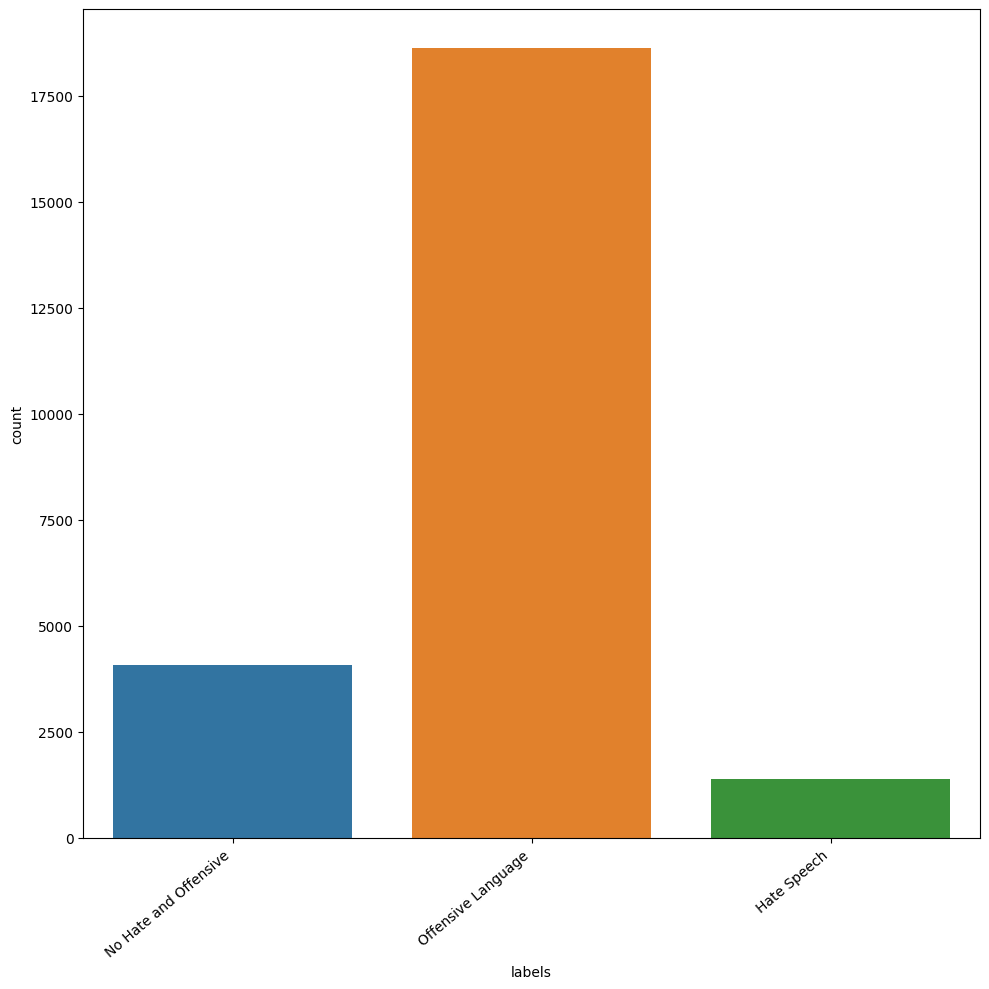

In [19]:
# How about we visualise these values instead:
fig = plt.figure(figsize=(10,10))

ax = sns.countplot(x='labels', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The dataset is more biased towards offensive language but less agaisnt Non hate & Offensive and Hate speech in that order 

Now we visualise a the words appearing in all 3 classes, using a word count. 
#### **NB:**
- Not for sensitive viewers

## 1. No Hate and No Offensive

In [20]:
# visualizing non-hate tweets
non_hate_tweets = data[data.labels=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,labels
0,rt woman shouldnt complain cleaning house amp ...,No Hate and Offensive
40,momma said pussy cats inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,woof woof hot soles,No Hate and Offensive
67,lemmie eat oreo amp dishes one oreo lol,No Hate and Offensive


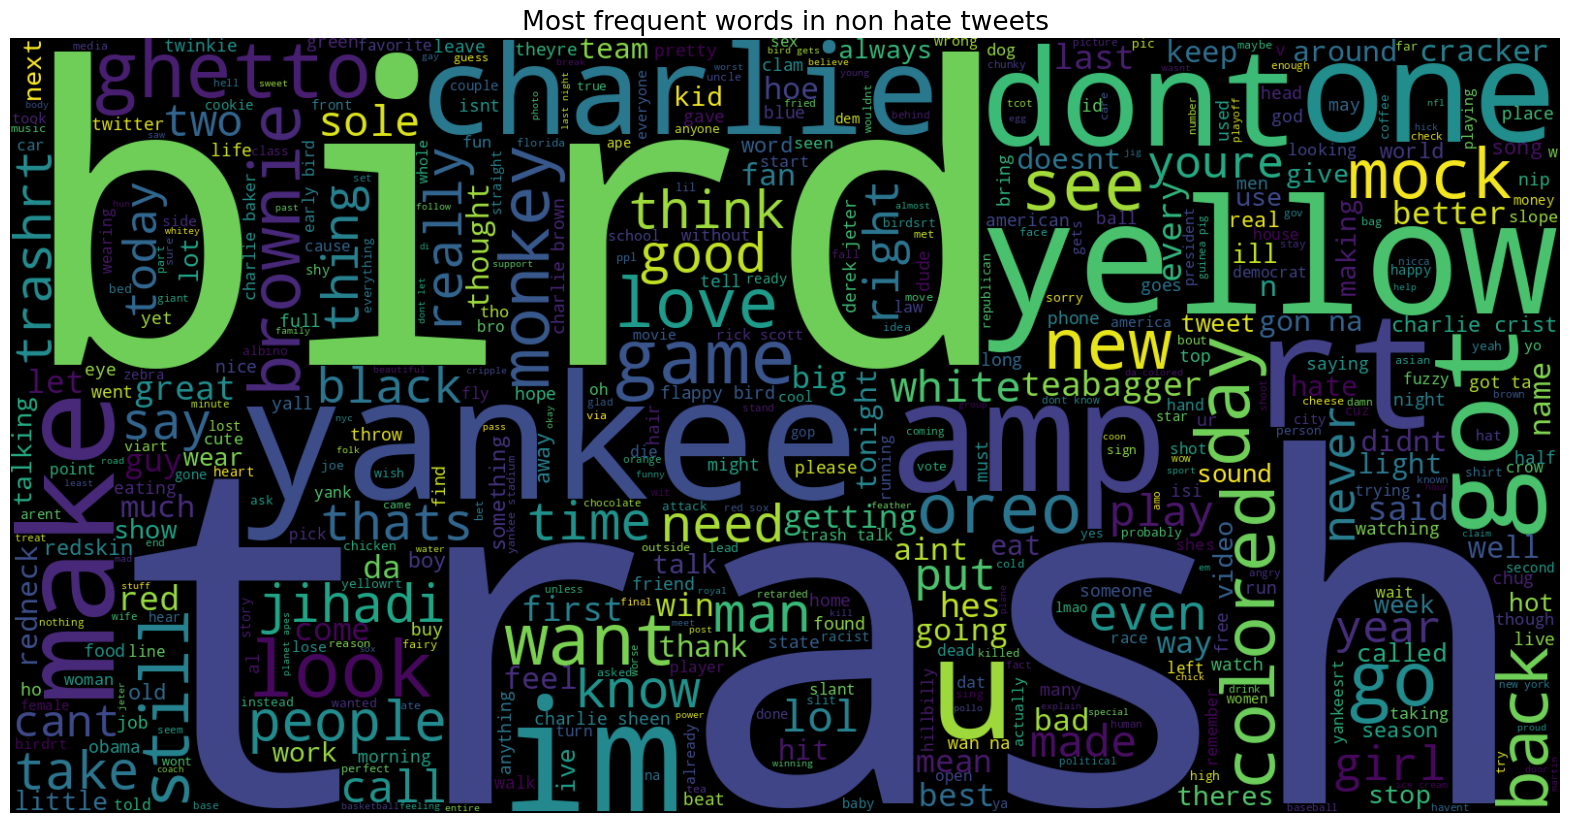

In [21]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

## 2. Offensive Language

In [22]:
offensive_tweets = data[data.labels=='Offensive Language']
offensive_tweets.head()

,tweet,labels
1,rt boy dats coldtyga dwn bad cuffin dat hoe place,Offensive Language
2,rt dawg rt ever fuck bitch start cry confused ...,Offensive Language
3,rt look like tranny,Offensive Language
4,rt shit hear might true might faker bitch told ya,Offensive Language
5,shit blows meclaim faithful somebody still fuc...,Offensive Language


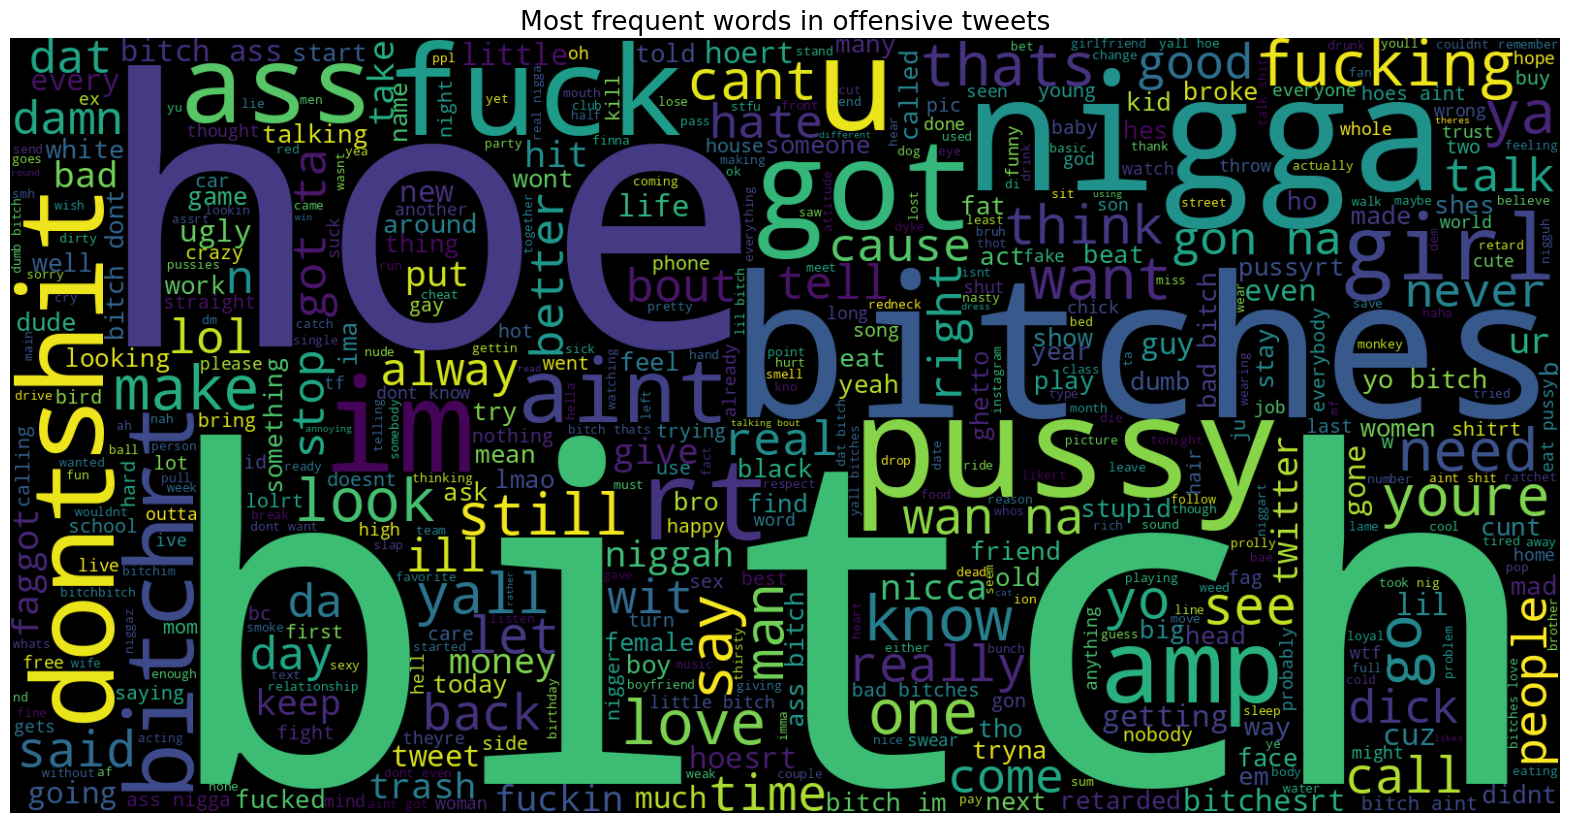

In [23]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in offensive_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in offensive tweets", fontsize=19)
plt.show()

## 3. Hate Speech

In [24]:
hate_tweets = data[data.labels=='Hate Speech']
hate_tweets.head()

,tweet,labels
85,queer gaywad,Hate Speech
89,alsarabsss hes beaner smh tell hes mexican,Hate Speech
110,youre fucking gay blacklisted hoe holding tehg...,Hate Speech
184,lmfaoooo hate black people theres black people...,Hate Speech
202,least im nigger lmfao,Hate Speech


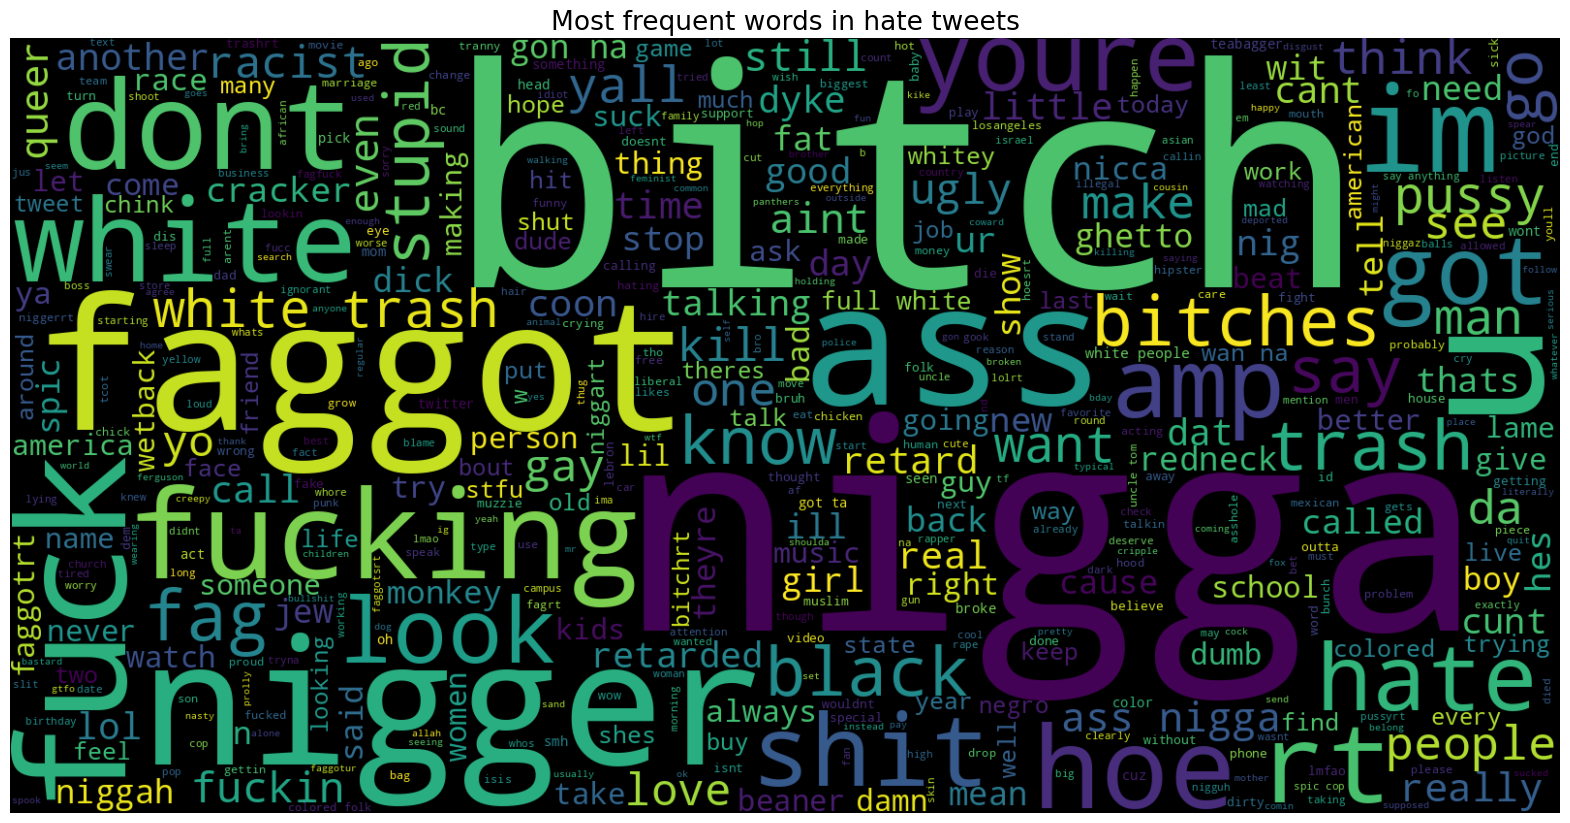

In [25]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in hate tweets", fontsize=19)
plt.show()

TF-IDF is a useful tool for converting a collection of raw documents (text) into a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency, which is a numerical statistic used to reflect the importance of a term in a document relative to a collection of documents.

We can have **Bigram model**, **Trigram model** and even **N-gram model** useful because they can be used to analyze patterns, predict words, or extract features for machine learning models. They provide more context than single words (unigrams) can provide. The names are self explanatory

In [26]:
"""# A TfidfVectorizer with bigram tokenization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))

# Fit-transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data['tweet'])

# Convert to DataFrame for easier viewing (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF matrix DataFrame
#print(tfidf_df)"""

"# A TfidfVectorizer with bigram tokenization\ntfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))\n\n# Fit-transform the text data\ntfidf_matrix = tfidf_vectorizer.fit_transform(data['tweet'])\n\n# Convert to DataFrame for easier viewing (optional)\ntfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())\n\n# Display the TF-IDF matrix DataFrame\n#print(tfidf_df)"

In [27]:
vect=TfidfVectorizer(ngram_range=(1,2)).fit(data['tweet'])

In [28]:


feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))



Number of features: {}
 136626
First 200 features: 
 ['aa' 'aa classes' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begins' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aampt'
 'aampt ackin' 'aamu' 'aan' 'aan de' 'aap' 'aap maoists' 'aap rocky'
 'aap shortsaid' 'aaron']


Now we try the Trigram Model

In [29]:
#creating a trigram language model
vect=TfidfVectorizer(ngram_range=(1,3)).fit(data['tweet'])

In [30]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 270775
First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aampt' 'aampt ackin' 'aampt ackin like'
 'aamu' 'aan' 'aan de']


# Model Building

In [31]:
X = data['tweet']
Y = data['labels']
X = vect.transform(X) #transforming the x data

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (19264, 270775)
Size of Y_train (19264,)
Size of X_test (4817, 270775)
Size of Y_test (4817,)


### 1. LINEAR REGRESSION MODEL

In [34]:
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 84.97%


Here is the classification report of the Regression Model trained above:

In [36]:
print(classification_report(Y_test, logreg_predict))

                       precision    recall  f1-score   support

          Hate Speech       0.69      0.04      0.08       269
No Hate and Offensive       0.89      0.52      0.65       866
   Offensive Language       0.85      0.99      0.91      3682

             accuracy                           0.85      4817
            macro avg       0.81      0.52      0.55      4817
         weighted avg       0.84      0.85      0.82      4817



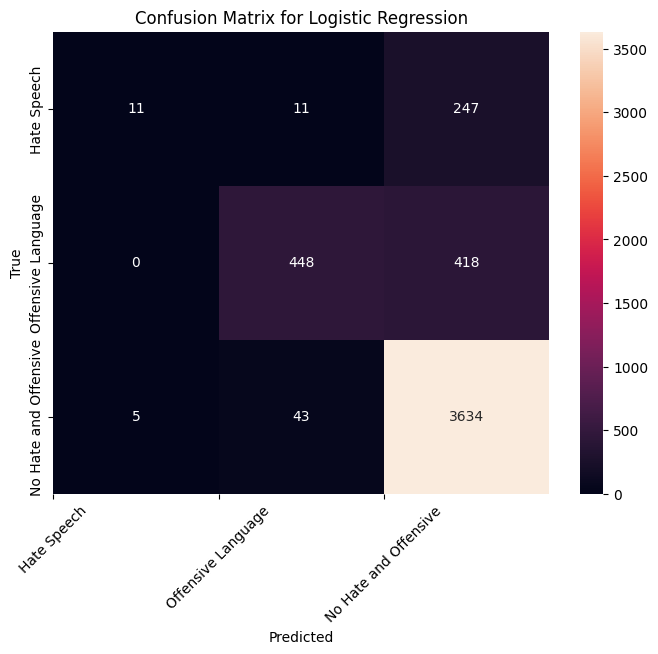

In [37]:
# Confusion matrix
cm = confusion_matrix(Y_test, logreg_predict)

# Define labels for the axes
labels = ['Hate Speech', 'Offensive Language', 'No Hate and Offensive']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression")
plt.xticks(ticks=[0, 1, 2], labels=labels, rotation=45)
plt.show()

### 2. SVM Model

In [38]:
# Instantiate the SVM classifier
svm = SVC()

# Fit the model to the training data
svm.fit(X_train, Y_train)

# Predict on the test data
svm_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, svm_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.846585011417895


In [39]:
print(classification_report(Y_test, svm_pred))

                       precision    recall  f1-score   support

          Hate Speech       0.79      0.04      0.08       269
No Hate and Offensive       0.90      0.50      0.64       866
   Offensive Language       0.84      0.99      0.91      3682

             accuracy                           0.85      4817
            macro avg       0.84      0.51      0.54      4817
         weighted avg       0.85      0.85      0.81      4817



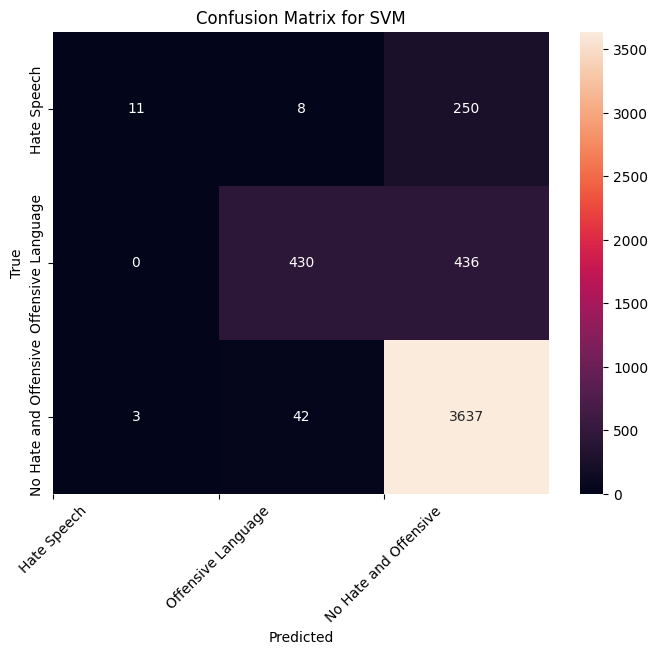

In [40]:
cm = confusion_matrix(Y_test, svm_pred)

# Define labels for the axes
labels = ['Hate Speech', 'Offensive Language', 'No Hate and Offensive']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.xticks(ticks=[0, 1, 2], labels=labels, rotation=45)
plt.show()

From the 2 models we implemented, the Linear Regression Model achieved an accuracy of 84.97% and the Support Vector Machine achieved an accuracy of 84.66%. The regressor model merely outperfomed the SVM model but now instead of selecting, let us just combine the 2 because though the former has a better perfomance, it would benefit from the later in determining Hate Specch etc. We let the models decide based on the voting Classifier

In [41]:
# Define the base models
estimators = [
    ('logistic_regression', LogisticRegression()),
    ('svm', SVC())
]

# Create the ensemble model
ensemble = VotingClassifier(estimators)

# Train the ensemble model
ensemble.fit(X_train, Y_train)

# Make predictions on the test set
ensemble_predictions = ensemble.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
print(classification_report(Y_test, ensemble_predictions))

                       precision    recall  f1-score   support

          Hate Speech       0.70      0.05      0.10       269
No Hate and Offensive       0.88      0.53      0.66       866
   Offensive Language       0.85      0.99      0.91      3682

             accuracy                           0.85      4817
            macro avg       0.81      0.52      0.56      4817
         weighted avg       0.85      0.85      0.82      4817



Test accuracy: 0.8511521694000416


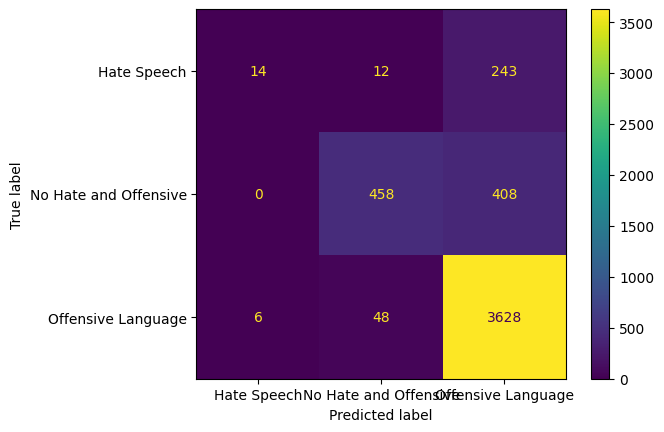

In [43]:
# Evaluate the ensemble model
accuracy = accuracy_score(Y_test, ensemble_predictions)
print("Test accuracy:", accuracy)

#for visualizing confusion matrix
#style.use('classic')
cm = confusion_matrix(Y_test, ensemble_predictions, labels=ensemble.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble.classes_)
disp.plot()

FINAL TESTING
1. 

In [44]:
# Preprocess the input sentence
input_sentence = "This is a clean statement that is meant strictly for testing and nothing else"
#data['tweet'] = data['tweet'].apply(lambda x: clean(x))
preprocessed_sentence = clean(input_sentence)

In [45]:
new_text_tfidf = vect.transform([preprocessed_sentence])
res_predicted = ensemble.predict(new_text_tfidf)

In [46]:
"""# Vectorize the preprocessed sentence using the same vocabulary as the training data
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), vocabulary=tfidf_vectorizer.vocabulary_)
X_input = tfidf_vectorizer.fit_transform([preprocessed_sentence])"""

'# Vectorize the preprocessed sentence using the same vocabulary as the training data\ntfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), vocabulary=tfidf_vectorizer.vocabulary_)\nX_input = tfidf_vectorizer.fit_transform([preprocessed_sentence])'

In [47]:
print(res_predicted)

['Offensive Language']


2.

In [48]:
# Preprocess the input sentence
input_sentence = "This code is not working"
preprocessed_sentence = clean(input_sentence)

In [49]:
new_text_tfidf = vect.transform([preprocessed_sentence])
res_predicted = ensemble.predict(new_text_tfidf)

print(res_predicted)

['Offensive Language']


3. 

In [50]:
# Preprocess the input sentence
input_sentence = "This code is not working"
preprocessed_sentence = clean(input_sentence)

In [51]:
new_text_tfidf = vect.transform([preprocessed_sentence])
res_predicted = ensemble.predict(new_text_tfidf)

print(res_predicted)

['Offensive Language']


4.

In [52]:
# Preprocess the input sentence
input_sentence = "Fuck this bitch"
preprocessed_sentence = clean(input_sentence)

In [53]:
new_text_tfidf = vect.transform([preprocessed_sentence])
res_predicted = ensemble.predict(new_text_tfidf)

print(res_predicted)

['Offensive Language']


### SAVING THE MODEL

In [56]:
pickle.dump(ensemble, open('model.pkl', 'wb'))

In [58]:
# save the model to disk
filename = 'HateSpeech_model.sav'
pickle.dump(ensemble, open(filename, 'wb'))